# Assignment 3
Prepared by Talha Alvi and Farhan Wadia

## Exercise 1 (Programming Exercise)

### Data

In [2]:
import pandas as pd
from smart_mobility_utilities.poi import poi
from smart_mobility_utilities.poi import drawRouteOrder
from smart_mobility_utilities.problem import ordOne_crossover, swap_mutation
from copy import deepcopy
import random
from heapq import nlargest
import matplotlib.pyplot as plt

depots = pd.read_csv("./carshare_depot.csv")
depot_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in depots.iterrows()]
pickups = pd.read_csv("./carshare_origin.csv")
pickup_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in pickups.iterrows()]
dropoffs = pd.read_csv("./carshare_dest.csv")
dropoff_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in dropoffs.iterrows()]

# Import a pre-calculated trip distance matrix
# These distances are based off of an osrm routing
tm = pd.read_csv("./trip_matrix.csv").values
trip_matrix = {}
all_points = depot_nodes + pickup_nodes + dropoff_nodes
for point in all_points:
    i = all_points.index(point)
    trip_matrix[point] = {}
    for point2 in all_points:
        j = all_points.index(point2)
        trip_matrix[point][point2] = tm[i][j+1]

### Genetic Algorithm with 3 Vehicles (to-do @Talha, partition into 3 clusters to use 3 vehicles)

#### Solution Class

In [3]:
class GACarSharingSolver:
    def __init__(
        self,
        depot_nodes,
        pickup_nodes,
        dropoff_nodes,
        trip_matrix,
        pop_size,
        iterations,
        num_parents,
        mutation_prob,
        crossover_prob,
        pre_avoid = [],
        post_avoid = []
    ):

        self.pickups = pickup_nodes
        self.depots = depot_nodes
        self.dropoffs = dropoff_nodes
        self.trip_matrix = trip_matrix
        self.pop_size = pop_size
        self.iterations = iterations
        self.num_parents = num_parents
        self.mutation_prob = mutation_prob
        self.crossover_prob = crossover_prob
        self.population = None
        self.costs = None
        self.states = []       
        self.solution = None
        self.solution_cost = None
        self.pre_avoid = pre_avoid
        self.post_avoid = post_avoid

    def crossover(parent1, parent2):
        return ordOne_crossover(parent1, parent2)

    def mutation(permutation):
        return swap_mutation(permutation)

    # Find the closest depots for start and end, avoiding ones that are already filled
    def find_depots(self, route):
        start = route[0]
        end = route[-1]
        depots = deepcopy(self.depots)
        tmp_depots = deepcopy(depots)
        [depots.pop(depots.index(x)) for x in self.pre_avoid if x in depots]
        distances_to_start = [self.trip_matrix[x][start] for x in depots]
        [depots.pop(depots.index(x)) for x in self.post_avoid if x in depots]
        distances_from_end = [self.trip_matrix[end][x] for x in depots]
        start_depot = tmp_depots[distances_to_start.index(min(distances_to_start))]
        end_depot = tmp_depots[distances_from_end.index(min(distances_from_end))]
        route = [start_depot] + route + [end_depot]
        return route

    # Creates a random route for pickups and calls find_depots to organize route to choose depots closest to start and end pick up points for the complete route
    def random_solution(self):
        route = []
        can_visit = deepcopy(self.pickups)
        for i in range(len(self.pickups)):
            # select a random pickup location
            random_pickup = random.choice(can_visit)
            route.append(random_pickup)
            can_visit.pop(can_visit.index(random_pickup))

        # now we can choose the depot closest to starting and ending locations
        route = self.find_depots(route)
        return route

    def expand_route(self, route):
        actual_route = []
        print(route)
        for stop in route:
            if stop not in self.pickups:
                # It is a depot
                actual_route.append(stop)
                continue
            actual_route.append(stop)
            drop = self.dropoffs[self.pickups.index(stop)]
            actual_route.append(drop)
        return actual_route

    def fitness(self, solutions):
        result = []
        for vehicle_route in solutions:
            # We need to expand the routes into pickup-dropoffs to calculate actual cost
            expanded_route = self.expand_route(vehicle_route)
            total = 0
            for stop, next_stop in zip(expanded_route[:-1], expanded_route[1:]):
                if stop in self.pickups and next_stop in self.dropoffs:
                    cost_factor = 0.5
                else:
                    cost_factor = -0.3
                total += cost_factor * self.trip_matrix[stop][next_stop]
            result.append(round(total,2))
        return result
    
    def initial_population(self):
        self.population = [
            self.random_solution()
            for _ in range(self.pop_size)
        ]
        self.costs = self.fitness(self.population)

    # Single vehicle, genetic algorithm
    def run(self):
        # Check that initial population exists:
        if self.population:
            # Show some information
            print("Initial Population costs:")
            print(self.costs)
        else:
            raise Exception("Population not initialized.")
        
        for _ in range(self.iterations):
            self.costs = self.fitness(self.population)
            self.states.append(max(self.costs))
            # Select the parents, we want to maximize the profit
            parents = nlargest(self.num_parents,self.population, key=lambda x: self.costs[self.population.index(x)])
            # Need to remove depots from the routes
            parents = [x[1:-1] for x in parents]
            offspring = []
            new_population = []
            for p1, p2 in zip(parents[:len(parents)//2],parents[len(parents)//2:]):
                # Crossover probability
                if random.random() < self.crossover_prob:
                    offspring.append(GACarSharingSolver.crossover(p1,p2))
                    offspring.append(GACarSharingSolver.crossover(p2,p1))
                else:
                    offspring.append(p1)
                    offspring.append(p2)
            for child in offspring:
                if random.random() < self.mutation_prob:
                    new_population.append(GACarSharingSolver.mutation(child))
                else:
                    new_population.append(child)
            new_population.extend(parents)
            self.population = [self.find_depots(route) for route in new_population]

        # Show best solution
        self.costs = self.fitness(self.population)
        self.states.append(max(self.costs))
        self.solution = max(self.population,key= lambda x: self.costs[self.population.index(x)])
        self.solution_cost = self.costs[self.population.index(self.solution)]
        self.solution = self.expand_route(self.solution)
        print("Best Solution:", self.solution)
        print("Best Solution Profits:", self.solution_cost)
        

    def visualize_solution(self, m=None, route_color="red", prefix=""):
        # define marker colors
        colors = []
        for stop in self.solution:
            if stop in self.depots:
                colors.append('blue')
            if stop in self.pickups:
                colors.append('green')
            if stop in self.dropoffs:
                colors.append('red')
        return drawRouteOrder(
            [x.coordinates[::-1] for x in self.solution],
            self.solution,
            range(1,len(self.solution)+1), 
            colors=colors, route_color=route_color, m=m, prefix=prefix)
    
    def visualize_graph(self):
        plt.plot(self.states)
        plt.xlabel("Iterations")
        plt.ylabel("Profit")
        plt.show()    

#### Solution

In [4]:
pop_size = 16
iterations = 1000
num_parents = 8
mutation_prob = 0.3
crossover_prob = 0.7

solver = GACarSharingSolver(
    depot_nodes, 
    pickup_nodes, 
    dropoff_nodes,
    trip_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_prob, 
    crossover_prob)

# Initialize the population
solver.initial_population()
solver.run()

[Name: Loblaws ID: 31582988, Name: Bayview Avenue ID: 2525612330, Name: October Convenience ID: 588647080, Name: 444 ID: 4035049080, Name: 799 ID: 401062600, Name: St. Barnabas Anglican Church ID: 43811604, Name: The Squire and Firkin ID: 2287594369, Name: Toronto Transit Commission ID: 32052212, Name: 90 ID: 804610960, Name: 565 ID: 803149738, Name: Bloor Street West ID: 2286883372, Name: 75 ID: 31812627]
[Name: 93 ID: 4035051033, Name: 565 ID: 803149738, Name: 90 ID: 804610960, Name: Bayview Avenue ID: 2525612330, Name: 799 ID: 401062600, Name: 444 ID: 4035049080, Name: St. Barnabas Anglican Church ID: 43811604, Name: The Squire and Firkin ID: 2287594369, Name: Bloor Street West ID: 2286883372, Name: Toronto Transit Commission ID: 32052212, Name: October Convenience ID: 588647080, Name: 75 ID: 31812627]
[Name: Loblaws ID: 31582988, Name: 90 ID: 804610960, Name: Bayview Avenue ID: 2525612330, Name: Bloor Street West ID: 2286883372, Name: The Squire and Firkin ID: 2287594369, Name: Oct

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[Name: 93 ID: 4035051033, Name: Toronto Transit Commission ID: 32052212, Name: Bayview Avenue ID: 2525612330, Name: 565 ID: 803149738, Name: St. Barnabas Anglican Church ID: 43811604, Name: 444 ID: 4035049080, Name: 90 ID: 804610960, Name: October Convenience ID: 588647080, Name: The Squire and Firkin ID: 2287594369, Name: Bloor Street West ID: 2286883372, Name: 799 ID: 401062600, Name: 93 ID: 4035051033]
[Name: 75 ID: 31812627, Name: The Squire and Firkin ID: 2287594369, Name: October Convenience ID: 588647080, Name: 799 ID: 401062600, Name: 565 ID: 803149738, Name: Bayview Avenue ID: 2525612330, Name: Toronto Transit Commission ID: 32052212, Name: St. Barnabas Anglican Church ID: 43811604, Name: 444 ID: 4035049080, Name: 90 ID: 804610960, Name: Bloor Street West ID: 2286883372, Name: 75 ID: 31812627]
[Name: Loblaws ID: 31582988, Name: Bayview Avenue ID: 2525612330, Name: Toronto Transit Commission ID: 32052212, Name: St. Barnabas Anglican Church ID: 43811604, Name: 444 ID: 4035049080

##### Visualization

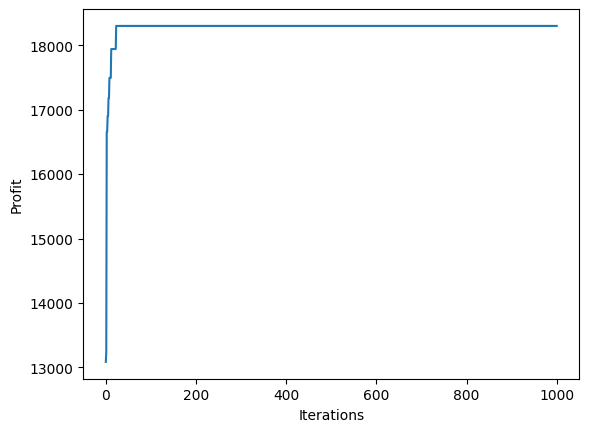

In [5]:
solver.visualize_graph()

In [6]:
solver.visualize_solution()

### Adaptive Genetic Algorithm with 3 Vehicles

### Particle Swarm Optimization with 3 Vehicles

In [ ]:
class PSOCarSharingSolver:
    def __init__(
        self,
        depot_nodes,
        pickup_nodes,
        dropoff_nodes,
        trip_matrix,
        num_particles,
        num_swarms,
        iterations,
        num_parents,
        pre_avoid = [],
        post_avoid = []
    ):

        self.pickups = pickup_nodes
        self.depots = depot_nodes
        self.dropoffs = dropoff_nodes
        self.trip_matrix = trip_matrix
        self.pop_size = pop_size
        self.iterations = iterations
        self.num_particles = num_particles
        self.num_swarms = num_swarms
        self.population = None
        self.costs = None
        self.states = []       
        self.solution = None
        self.solution_cost = None
        self.pre_avoid = pre_avoid
        self.post_avoid = post_avoid

### Adaptive Particle Swarm Optimization with 3 Vehicles

### Comparison of Algorithms

Conduct a comparative analysis on genetic algorithm, adaptive genetic algorithm, swarm intelligence algorithm and adaptive swarm intelligence algorithm in terms of the generated profit, CPU times and Wall time spent in getting the solutions.